# Code

In [18]:
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))

In [19]:
%load_ext autoreload
%load_ext autotime
%load_ext nb_black
%autoreload 2

time: 469 ms (started: 2023-08-07 18:52:44 +03:00)


<IPython.core.display.Javascript object>

In [ ]:
!pip install properscoring 

In [ ]:
from numba import njit
from math import floor
from matplotlib import pyplot as plt

@njit()
def fast_calibration_binning(y_true: np.ndarray, y_pred: np.ndarray, nbins: int = 100):
    """Computes bins of predicted vs actual events frequencies. Corresponds to sklearn's UNIFORM strategy."""

    pockets_predicted = np.zeros(nbins, dtype=np.int64)
    pockets_true = np.zeros(nbins, dtype=np.int64)

    min_val, max_val = 1.0, 0.0
    for predicted_prob in y_pred:
        if predicted_prob > max_val:
            max_val = predicted_prob
        elif predicted_prob < min_val:
            min_val = predicted_prob
    span = max_val - min_val
    multiplier = nbins / span
    for true_class, predicted_prob in zip(y_true, y_pred):
        ind = floor((predicted_prob - min_val) * multiplier)
        pockets_predicted[ind] += 1
        pockets_true[ind] += true_class

    idx = np.nonzero(pockets_predicted > 0)[0]

    hits = pockets_true[idx]
    freqs_predicted, freqs_true = min_val + (np.arange(nbins)[idx] + 0.5) * span / nbins, hits / pockets_predicted[idx]

    return freqs_predicted, freqs_true, hits


def show_calibration_plot(
    freqs_predicted: np.ndarray,
    freqs_true: np.ndarray,
    hits: np.ndarray,
    show_plots: bool = True,
    plot_file: str = "",
    plot_title: str = "",
    figsize: tuple = (12, 6),
):
    """Plots reliability digaram from the binned predictions."""
    fig = plt.figure(figsize=figsize)
    plt.scatter(freqs_predicted, freqs_true, marker="o", s=5000 * hits / hits.sum(), c=hits, label="Real")
    x_min, x_max = np.min(freqs_predicted), np.max(freqs_predicted)
    plt.plot([x_min, x_max], [x_min, x_max], "g--", label="Perfect")
    if plot_title:
        plt.title(plot_title)
    if plot_file:
        fig.savefig(plot_file)
    if show_plots:
        plt.show()
    else:
        plt.close(fig)


def fast_calibration_report(y_true: np.ndarray, y_pred: np.ndarray, nbins: int = 100, show_plots: bool = True, plot_file: str = "", figsize: tuple = (12, 6)):
    """Bins predictions, then computes regresison-like error metrics between desired and real binned probs."""

    freqs_predicted, freqs_true, hits = fast_calibration_binning(y_true=y_true, y_pred=y_pred, nbins=nbins)
    diffs = np.abs((freqs_predicted - freqs_true))
    calibration_mae, calibration_std = np.mean(diffs), np.std(diffs)

    if plot_file or show_plots:
        show_calibration_plot(
            freqs_predicted=freqs_predicted,
            freqs_true=freqs_true,
            hits=hits,
            plot_title=f"Calibration MAE={calibration_mae:.4f} ± {calibration_std:.4f}",
            show_plots=show_plots,
            plot_file=plot_file,
            figsize=figsize,
        )

    return calibration_mae, calibration_std

In [180]:
import numpy as np, pandas as pd


def generate_data(
    size=30_000,
    baseline_prob: float = None,
    impact_span: float = None,
    fuzzy_influence: bool = False,
    fuzzy_baseline_prob: float = None,
    fuzzy_impact_span: float = None,
    clip_lim: float = 1e-2,
) -> tuple:
    """Generates known probabilities and then samples binary outcomes (realizations) from them.
    Known probabilities can be created uniformly (with default prameters) or with density focused in certain area, specified by baseline_prob and impact_span parameters.
    The latter is useful to simulate class imbalance problems, when occurence of minority class is rare and traditional metrics perform poorly.
    Sampling can be done
        1) directly with fuzzy_influence = False. Generated probs become ral underlying probs of the generated realizations.
        2) indirectly/fuzzily with fuzzy_influence = True. In this case, simulating only partial knowledge of influencing factors, bulk of true underlying probabilities
        is defined by unknown values drawn from separately created uniform distribution, but with our known probs added. This is to model a situation where our ML tools
        are able to generalize from partial information contained at least in observed data: model would use overall classes balance as a base figure, plus add its
        ML knowledge distilled from supplied features. The ratio of known/unknown influence can be regulated by fuzzy_baseline_prob and fuzzy_impact_span params.
    """
    known_probs = np.random.uniform(size=size)
    if baseline_prob and impact_span:
        known_probs = np.clip(baseline_prob + (known_probs - 0.5) * impact_span, clip_lim, 1 - clip_lim)

    if fuzzy_influence:
        fuzzy_probs = np.random.uniform(size=size)
        if fuzzy_baseline_prob and fuzzy_impact_span:
            fuzzy_probs = np.clip(fuzzy_baseline_prob + (fuzzy_probs - 0.5) * fuzzy_impact_span, clip_lim, 1 - clip_lim)
        probs = np.clip(known_probs + fuzzy_probs, clip_lim, 1 - clip_lim)
        known_probs = np.clip(known_probs + fuzzy_probs.mean(), clip_lim, 1 - clip_lim)
    else:
        probs = known_probs
    realizations = (np.random.uniform(size=size) < probs).astype(np.int8)

    return known_probs, realizations


from sklearn.metrics import average_precision_score, roc_auc_score, brier_score_loss, classification_report
from imblearn.metrics import classification_report_imbalanced
from properscoring import crps_ensemble, brier_score
from mlframe.metrics import fast_calibration_report
from imblearn.metrics import geometric_mean_score
from tqdm import tqdm

ndigits = 4


def compute_metrics_block(realizations: np.ndarray, probs: np.ndarray, print_block_name: str = None, ndigits: int = 4) -> tuple:
    """Computes a set of metrics from a realizations/probs arrays pair."""
    calibration_mae, calibration_std = fast_calibration_report(y_true=realizations, y_pred=probs, nbins=10, show_plots=False)
    brier_vals = brier_score(observations=realizations, forecasts=probs)
    crps_vals = crps_ensemble(
        observations=realizations,
        forecasts=probs,
    )
    gms = geometric_mean_score(y_true=realizations, y_pred=probs > 0.5, average="weighted")
    pr_auc = average_precision_score(
        y_true=realizations,
        y_score=probs,
    )
    roc_auc = roc_auc_score(
        y_true=realizations,
        y_score=probs,
    )

    if print_block_name:
        print(
            f"{print_block_name} perf: GMS={gms:.{ndigits}f}, PR AUC={pr_auc:.{ndigits}f}, ROC AUC={roc_auc}, BR MEAN={brier_vals.mean():.{ndigits}f}, BR STD={brier_vals.std():.{ndigits}f}, CRPS MEAN={crps_vals.mean():.{ndigits}f}, CRPS STD={crps_vals.std():.{ndigits}f}, CALIB MAE={calibration_mae:.{ndigits}f}, CALIB STD={calibration_std:.{ndigits}f}"
        )

    return gms, pr_auc, roc_auc, calibration_mae, calibration_std, brier_vals, crps_vals


def show_ideal_vs_random(
    probs: np.ndarray,
    realizations: np.ndarray,
    show_bins=[2, 10, 100],
    figsize: tuple = (9, 4),
    nsummary_runs: int = 0,
    gen_func: object = None,
) -> None:
    """Takes true probabilities and a snapshot of their outcomes, compares a range of classification ML metrics for
    1) true probabilities
    2) completely unrelated probabilities sampled randomly

    Capable ML metrics should be able to separate true underlying probabilities from unrelated junk.

    Draws calibration plots for a set of bins.
    """

    columns = "gms pr_auc roc_auc calib_mae calib_std calib_mae_std br_mean br_std br_mean_std crps_mean crps_std crps_mean_std".split()
    misclassifications = np.zeros(len(columns), dtype=np.int64)
    lines = []
    for j in tqdm(range(nsummary_runs + 1)):
        if not nsummary_runs:
            print("True classification report:")
            print(classification_report(y_true=realizations, y_pred=probs > 0.5, digits=ndigits, zero_division=0))
        if gen_func:
            probs, realizations = gen_func()
        gms, pr_auc, roc_auc, calibration_mae, calibration_std, brier_vals, crps_vals = compute_metrics_block(
            realizations=realizations, probs=probs, print_block_name="True" if not nsummary_runs else None, ndigits=ndigits
        )
        if nsummary_runs:
            meaningful_model_metrics = [gms, pr_auc, roc_auc, calibration_mae, calibration_std, calibration_mae + calibration_std / 2]
            for arr in (brier_vals, crps_vals):
                arr_mean, arr_std = arr.mean(), arr.std()
                meaningful_model_metrics.extend([arr_mean, arr_std, arr_mean + arr_std / 2])
        tmp = np.random.uniform(size=len(probs))
        gms, pr_auc, roc_auc, calibration_mae, calibration_std, brier_vals, crps_vals = compute_metrics_block(
            realizations=realizations, probs=tmp, print_block_name="Rand" if not nsummary_runs else None, ndigits=ndigits
        )
        if nsummary_runs:
            junk_model_metrics = [gms, pr_auc, roc_auc, calibration_mae, calibration_std, calibration_mae + calibration_std / 2]
            for arr in (brier_vals, crps_vals):
                arr_mean, arr_std = arr.mean(), arr.std()
                junk_model_metrics.extend([arr_mean, arr_std, arr_mean + arr_std / 2])

            line = []
            for i in range(len(junk_model_metrics)):
                if i < 3:
                    ratio = meaningful_model_metrics[i] / junk_model_metrics[i]
                else:
                    ratio = junk_model_metrics[i] / meaningful_model_metrics[i]
                if ratio < 1:
                    misclassifications[i] += 1
                line.append(ratio)
            lines.append(line)
        else:
            if show_bins:
                for nbins in show_bins:
                    calibration_mae, calibration_std = fast_calibration_report(
                        y_true=realizations,
                        y_pred=probs,
                        nbins=nbins,
                        figsize=figsize,
                    )
        if j >= nsummary_runs - 1:
            break
    if nsummary_runs:
        ratios = pd.DataFrame(data=lines, columns=columns)
        misclassifications = pd.Series(data=misclassifications / nsummary_runs, index=columns)
        return ratios, misclassifications

time: 15 ms (started: 2023-08-08 03:09:50 +03:00)


<IPython.core.display.Javascript object>

# Quick glance

True classification report:
              precision    recall  f1-score   support

           0     0.7478    0.7582    0.7530      5021
           1     0.7527    0.7421    0.7474      4979

    accuracy                         0.7502     10000
   macro avg     0.7502    0.7502    0.7502     10000
weighted avg     0.7502    0.7502    0.7502     10000

True perf: GMS=0.7502, PR AUC=0.8333, ROC AUC=0.8329854538634062, BR MEAN=0.1669, BR STD=0.1994, CRPS MEAN=0.3322, CRPS STD=0.2377, CALIB MAE=0.0064, CALIB STD=0.0036
Rand perf: GMS=0.5079, PR AUC=0.5055, ROC AUC=0.513314334864867, BR MEAN=0.3278, BR STD=0.2988, CRPS MEAN=0.4933, CRPS STD=0.2906, CALIB MAE=0.2422, CALIB STD=0.1332


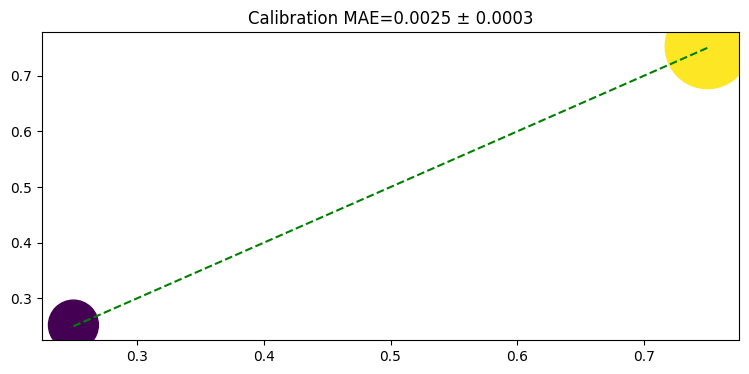

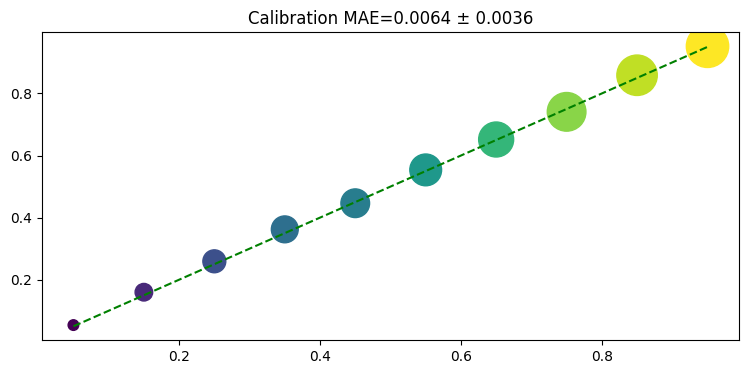

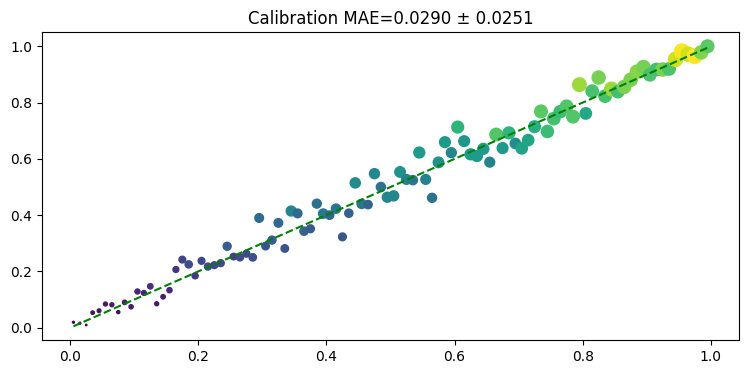

time: 390 ms (started: 2023-08-08 02:46:23 +03:00)


<IPython.core.display.Javascript object>

In [143]:
probs, realizations = generate_data(size=10_000, baseline_prob=None, impact_span=None)
show_ideal_vs_random(probs=probs, realizations=realizations)

True classification report:
              precision    recall  f1-score   support

           0     0.9607    1.0000    0.9800      9607
           1     0.0000    0.0000    0.0000       393

    accuracy                         0.9607     10000
   macro avg     0.4803    0.5000    0.4900     10000
weighted avg     0.9229    0.9607    0.9414     10000

True perf: GMS=0.1943, PR AUC=0.0543, ROC AUC=0.6118206322732761, BR MEAN=0.0376, BR STD=0.1771, CRPS MEAN=0.0761, CRPS STD=0.1782, CALIB MAE=0.0037, CALIB STD=0.0019
Rand perf: GMS=0.5019, PR AUC=0.0416, ROC AUC=0.5070812180791625, BR MEAN=0.3385, BR STD=0.3005, CRPS MEAN=0.5046, CRPS STD=0.2897, CALIB MAE=0.4608, CALIB STD=0.2863


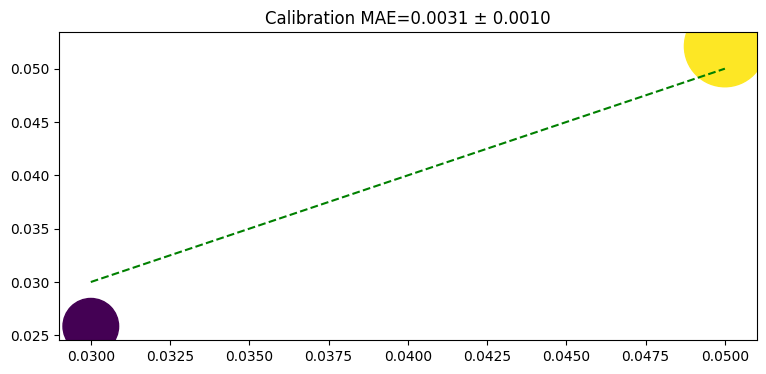

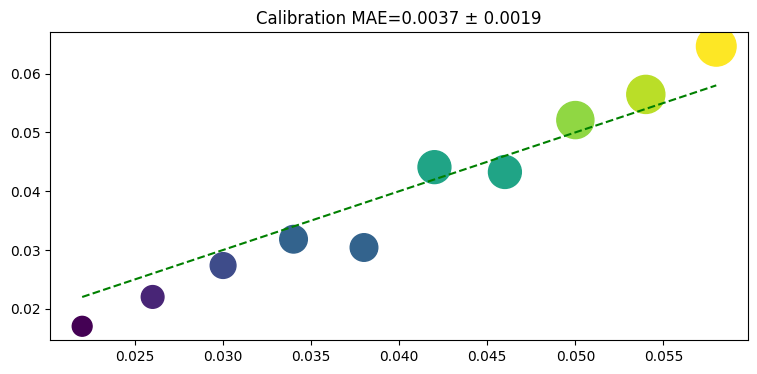

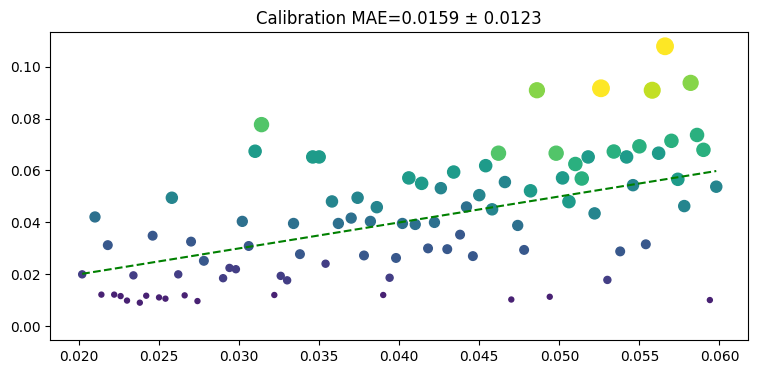

time: 797 ms (started: 2023-08-08 02:35:22 +03:00)


<IPython.core.display.Javascript object>

In [141]:
probs, realizations = generate_data(size=10_000, baseline_prob=0.04, impact_span=0.04)
show_ideal_vs_random(probs=probs, realizations=realizations)

True classification report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000      4624
           1     0.5376    1.0000    0.6993      5376

    accuracy                         0.5376     10000
   macro avg     0.2688    0.5000    0.3496     10000
weighted avg     0.2890    0.5376    0.3759     10000

True perf: GMS=0.4986, PR AUC=0.5357, ROC AUC=0.4976, BR MEAN=0.2488, BR STD=0.0431, CRPS MEAN=0.4969, CRPS STD=0.0431, CALIB MAE=0.0160, CALIB STD=0.0092
Rand perf: GMS=0.4971, PR AUC=0.5395, ROC AUC=0.5002, BR MEAN=0.3319, BR STD=0.2942, CRPS MEAN=0.4999, CRPS STD=0.2863, CALIB MAE=0.2527, CALIB STD=0.1428


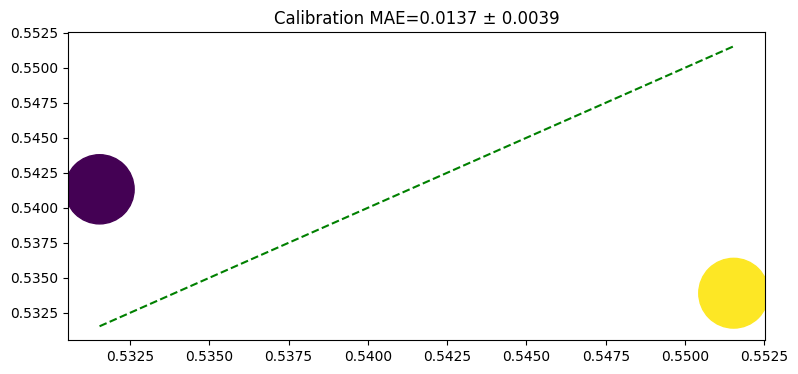

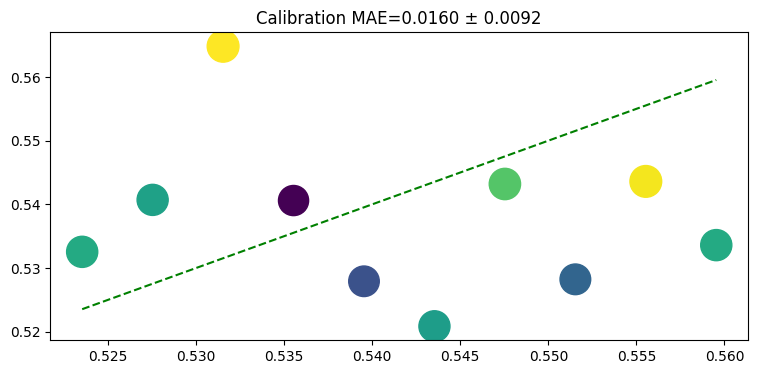

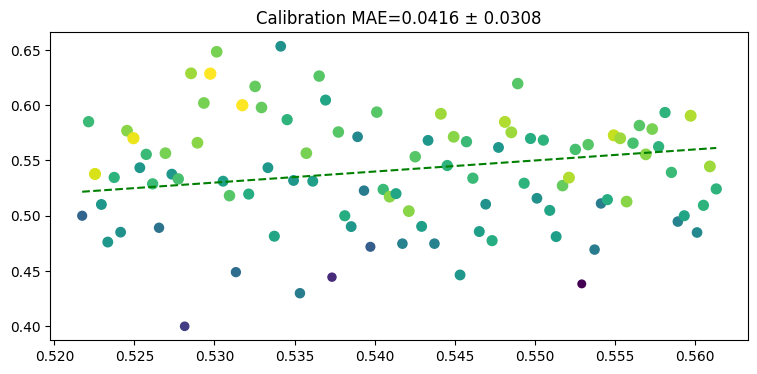

time: 469 ms (started: 2023-08-08 01:34:56 +03:00)


<IPython.core.display.Javascript object>

In [132]:
probs, realizations = generate_data(size=10_000, baseline_prob=0.04, impact_span=0.04, fuzzy_influence=True)
show_ideal_vs_random(probs=probs, realizations=realizations)

# Stats

In [197]:
ratios, misclassifications = show_ideal_vs_random(
    probs=None, realizations=None, nsummary_runs=100_000, gen_func=lambda: generate_data(size=10_000, baseline_prob=None, impact_span=None)
)
misclassifications

100%|██████████████████████████████████████████████████████████████████████████▉| 99999/100001 [30:14<00:00, 55.10it/s]


gms              0.0
pr_auc           0.0
roc_auc          0.0
calib_mae        0.0
calib_std        0.0
calib_mae_std    0.0
br_mean          0.0
br_std           0.0
br_mean_std      0.0
crps_mean        0.0
crps_std         0.0
crps_mean_std    0.0
dtype: float64

time: 30min 15s (started: 2023-08-08 03:26:39 +03:00)


<IPython.core.display.Javascript object>

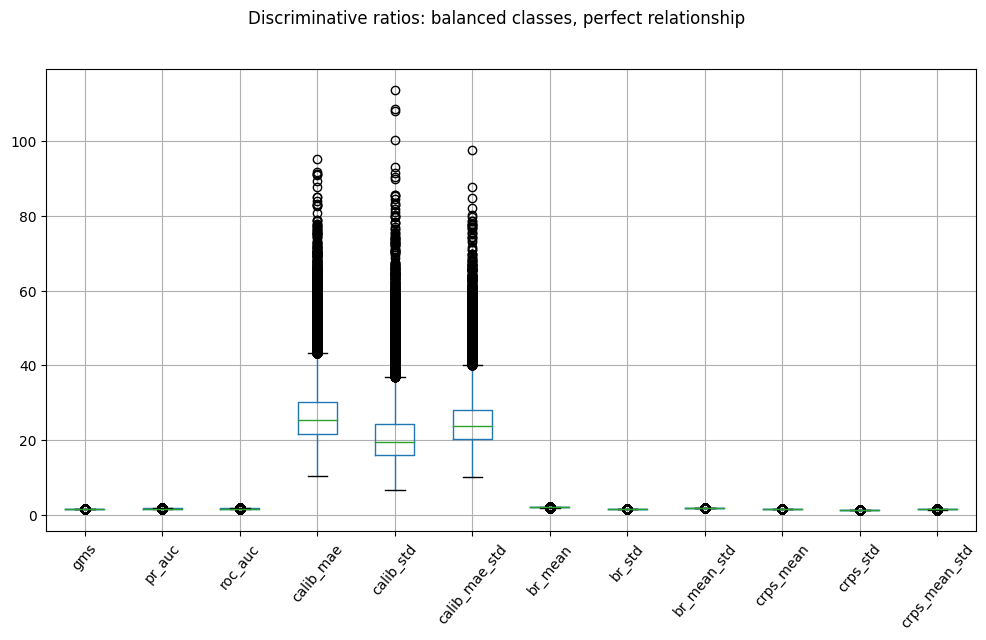

time: 1.25 s (started: 2023-08-08 03:56:54 +03:00)


<IPython.core.display.Javascript object>

In [198]:
ax = ratios.boxplot(figsize=(12, 6), rot=50)
_ = ax.get_figure().suptitle("Discriminative ratios: balanced classes, perfect relationship")

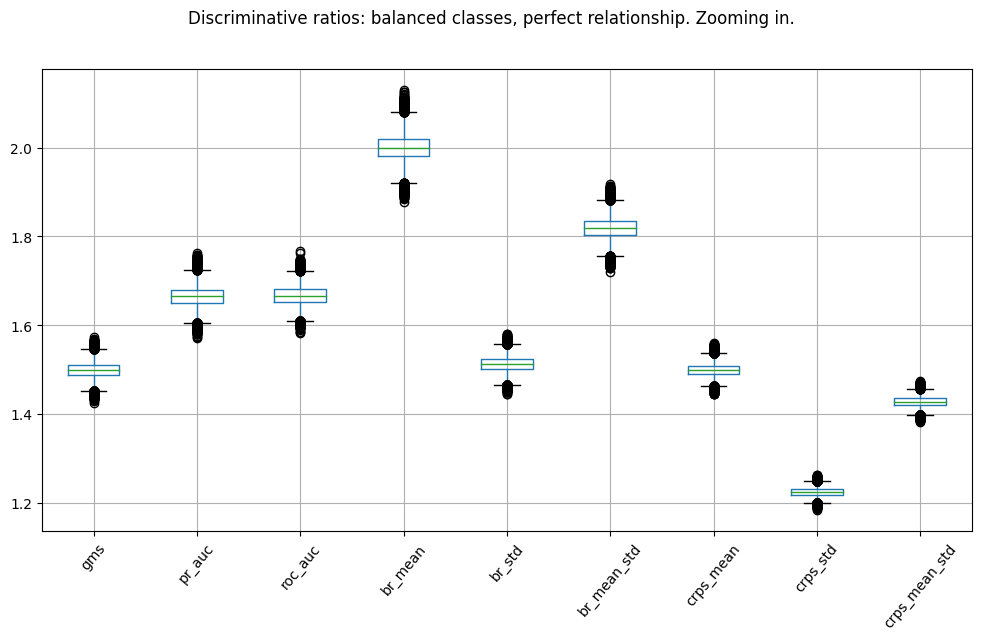

time: 922 ms (started: 2023-08-08 03:56:56 +03:00)


<IPython.core.display.Javascript object>

In [199]:
ax = ratios.boxplot(figsize=(12, 6), rot=50, column="gms pr_auc roc_auc br_mean br_std br_mean_std crps_mean crps_std crps_mean_std".split())
_ = ax.get_figure().suptitle("Discriminative ratios: balanced classes, perfect relationship. Zooming in.")

In [200]:
ratios, misclassifications = show_ideal_vs_random(
    probs=None, realizations=None, nsummary_runs=100_000, gen_func=lambda: generate_data(size=10_000, baseline_prob=0.04, impact_span=0.04)
)
misclassifications

100%|██████████████████████████████████████████████████████████████████████████▉| 99999/100001 [29:27<00:00, 56.57it/s]


gms              1.00000
pr_auc           0.00116
roc_auc          0.00001
calib_mae        0.00000
calib_std        0.00000
calib_mae_std    0.00000
br_mean          0.00000
br_std           0.00000
br_mean_std      0.00000
crps_mean        0.00000
crps_std         0.00000
crps_mean_std    0.00000
dtype: float64

time: 29min 28s (started: 2023-08-08 03:56:57 +03:00)


<IPython.core.display.Javascript object>

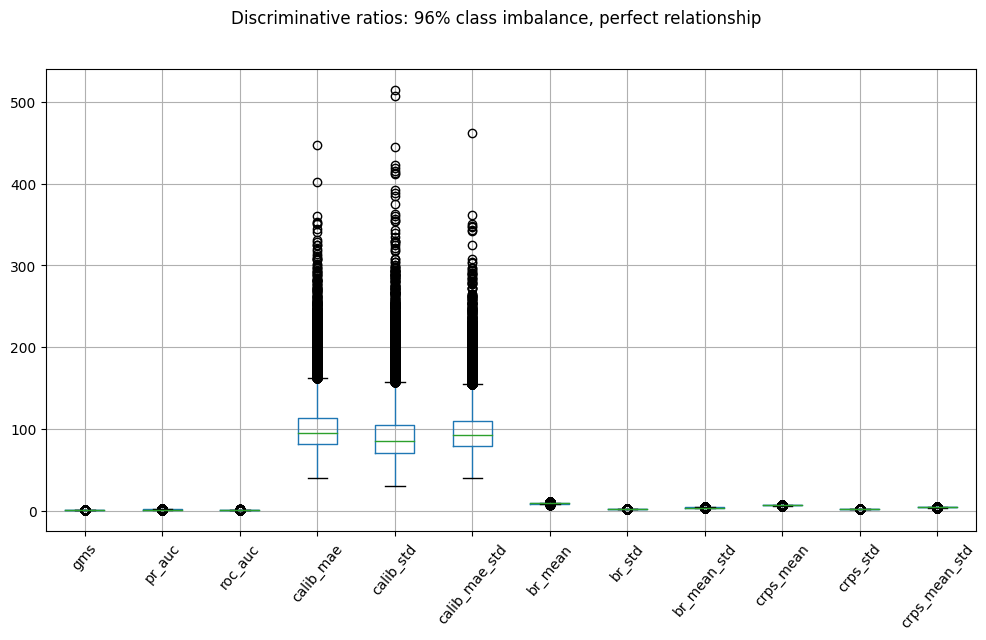

time: 1.39 s (started: 2023-08-08 04:26:25 +03:00)


<IPython.core.display.Javascript object>

In [201]:
ax = ratios.boxplot(figsize=(12, 6), rot=50)
_ = ax.get_figure().suptitle("Discriminative ratios: 96% class imbalance, perfect relationship")

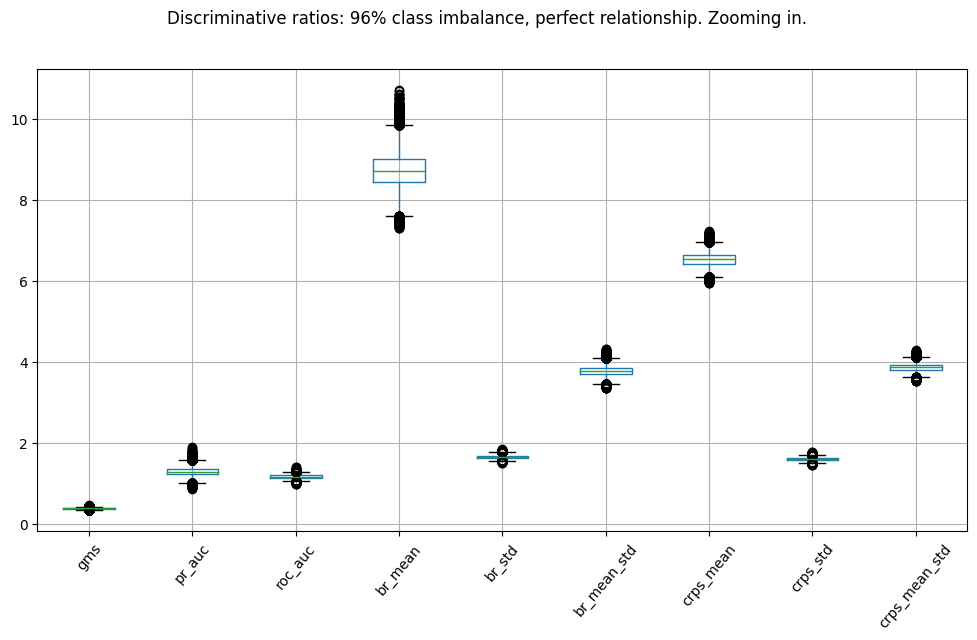

time: 1.05 s (started: 2023-08-08 04:26:26 +03:00)


<IPython.core.display.Javascript object>

In [202]:
ax = ratios.boxplot(figsize=(12, 6), rot=50, column="gms pr_auc roc_auc br_mean br_std br_mean_std crps_mean crps_std crps_mean_std".split())
_ = ax.get_figure().suptitle("Discriminative ratios: 96% class imbalance, perfect relationship. Zooming in.")

In [203]:
ratios, misclassifications = show_ideal_vs_random(
    probs=None,
    realizations=None,
    nsummary_runs=100_000,
    gen_func=lambda: generate_data(size=10_000, baseline_prob=0.04, impact_span=0.04, fuzzy_influence=True),
)
misclassifications

100%|██████████████████████████████████████████████████████████████████████████▉| 99999/100001 [35:58<00:00, 46.32it/s]


gms              0.61855
pr_auc           0.08957
roc_auc          0.05973
calib_mae        0.00000
calib_std        0.00000
calib_mae_std    0.00000
br_mean          0.00000
br_std           0.00000
br_mean_std      0.00000
crps_mean        0.12553
crps_std         0.00000
crps_mean_std    0.00000
dtype: float64

time: 35min 59s (started: 2023-08-08 04:26:28 +03:00)


<IPython.core.display.Javascript object>

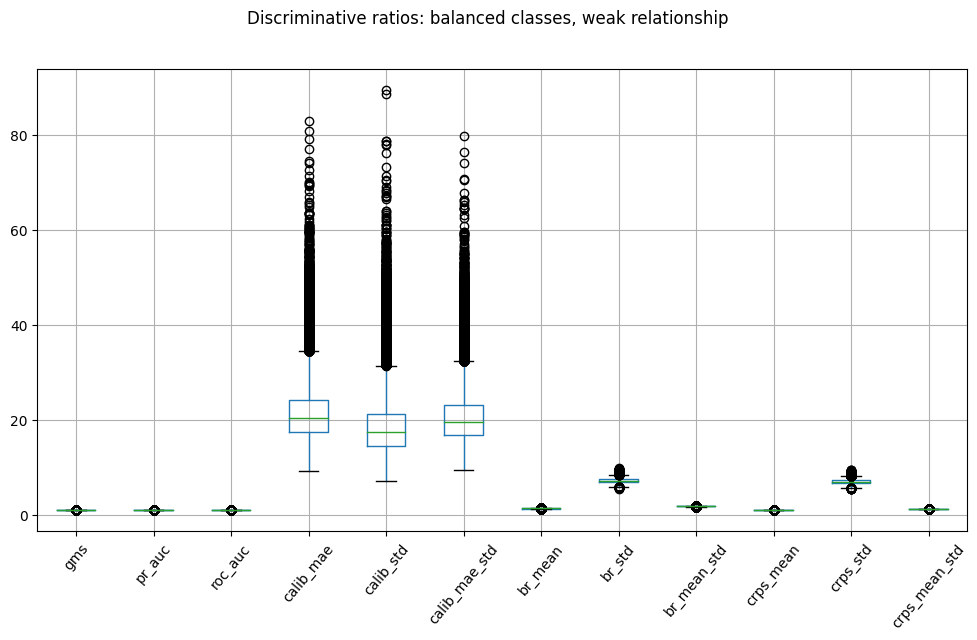

time: 1.36 s (started: 2023-08-08 05:02:27 +03:00)


<IPython.core.display.Javascript object>

In [204]:
ax = ratios.boxplot(figsize=(12, 6), rot=50)
_ = ax.get_figure().suptitle("Discriminative ratios: balanced classes, weak relationship")

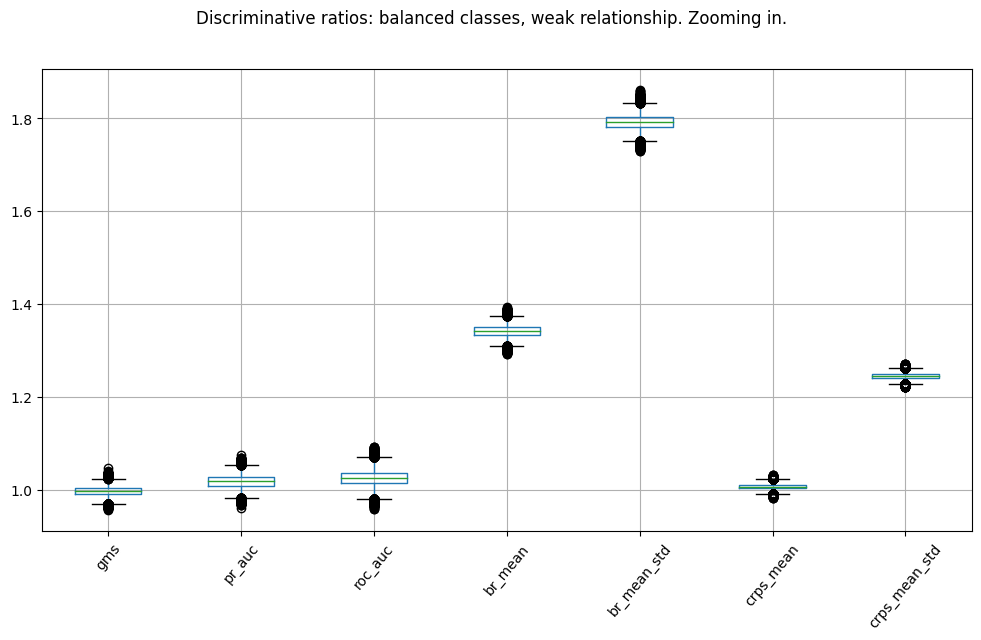

time: 1.2 s (started: 2023-08-08 05:02:29 +03:00)


<IPython.core.display.Javascript object>

In [205]:
ax = ratios.boxplot(figsize=(12, 6), rot=50, column="gms pr_auc roc_auc br_mean br_mean_std crps_mean crps_mean_std".split())
_ = ax.get_figure().suptitle("Discriminative ratios: balanced classes, weak relationship. Zooming in.")

# SPEED CHECKS

In [208]:
%timeit calibration_mae, calibration_std = fast_calibration_report(y_true=realizations, y_pred=probs, nbins=10, show_plots=False)

74.9 µs ± 2.45 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
time: 6.08 s (started: 2023-08-08 05:34:14 +03:00)


<IPython.core.display.Javascript object>

In [210]:
%%timeit
crps_vals = crps_ensemble(
    observations=realizations,
    forecasts=probs,
)
crps_vals.mean(),crps_vals.std()

73.1 µs ± 2.38 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
time: 5.91 s (started: 2023-08-08 05:35:26 +03:00)


<IPython.core.display.Javascript object>

In [209]:
%%timeit
brier_vals = brier_score(observations=realizations, forecasts=probs)
brier_vals.mean(),brier_vals.std()

239 µs ± 15.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
time: 1.92 s (started: 2023-08-08 05:34:52 +03:00)


<IPython.core.display.Javascript object>

In [211]:
%%timeit
pr_auc = average_precision_score(
    y_true=realizations,
    y_score=probs,
)

1.92 ms ± 70.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
time: 15.6 s (started: 2023-08-08 05:35:46 +03:00)


<IPython.core.display.Javascript object>

In [212]:
%%timeit
roc_auc = roc_auc_score(
    y_true=realizations,
    y_score=probs,
)

2.94 ms ± 37.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
time: 2.39 s (started: 2023-08-08 05:36:02 +03:00)


<IPython.core.display.Javascript object>